In [77]:
import xarray as xr
from glob import glob
import numpy as np
from dataclasses import dataclass
from matplotlib import pyplot as plt
from scipy.signal import medfilt
import pandas as pd

In [78]:
def extract_grouped_data(file_obj) -> xr.Dataset:
    ku_ds = xr.open_dataset(file_obj, group='data_01/ku')
    ku_sub_ds = ku_ds[['sig0_ocean_nr', 'range_ocean_nr_qual', 'swh_ocean_nr', 'ssha_nr']]

    ds = xr.open_dataset(file_obj, group='data_01')
    sub_ds = ds[['latitude', 'longitude', 'time',
                'rad_water_vapor_qual', 'rain_flag', 'surface_classification_flag']]

    ds = xr.merge([sub_ds, ku_sub_ds])
    ds.attrs = xr.open_dataset(file_obj).attrs
    return ds
    
s6_files = glob('/Users/username/Developer/Measures-Cloud/data/S6/cycle_103/*.nc')
s6_files.sort()

all_granules = [extract_grouped_data(fp) for fp in s6_files]
ds = xr.concat(all_granules, dim='time')

KeyboardInterrupt: 

In [515]:

ds = xr.open_dataset('/Users/username/Developer/Measures-Cloud/repos/daily_files/cycle_103.nc')
ds

<xarray.Dataset>
Dimensions:                      (time: 849211)
Coordinates:
  * time                         (time) datetime64[ns] 2023-08-26T01:40:57 .....
    latitude                     (time) float64 ...
    longitude                    (time) float64 ...
Data variables:
    rad_water_vapor_qual         (time) float32 ...
    rain_flag                    (time) float32 ...
    surface_classification_flag  (time) float32 ...
    sig0_ocean_nr                (time) float32 ...
    range_ocean_nr_qual          (time) float32 ...
    swh_ocean_nr                 (time) float32 ...
    ssha_nr                      (time) float64 ...
Attributes: (12/63)
    Convention:                             CF-1.7
    institution:                            EUMETSAT
    references:                             Sentinel-6_Jason-CS ALT Generic P...
    contact:                                ops@eumetsat.int
    radiometer_sensor_name:                 AMR-C
    doris_sensor_name:                      DORIS
    ...                                     ...
    xref_pressure_var:                      S6__P4_2__S12P_AX_20151008T000000...
    xref_sea_state_bias:                    S6A_P4_2__SSBL_AX_20151008T000000...
    xref_solid_earth_tide:                  S6__P4_2__SETD_AX_20151008T000000...
    xref_surface_classification:            S6__P4____SURF_AX_20151008T000000...
    xref_wind_speed_alt:                    S6A_P4_2__WNDL_AX_20151008T000000...
    product_name:                           S6A_P4_2__LR______20230826T014056...

In [509]:
kqual = ds.range_ocean_nr_qual.values
surfc = ds.surface_classification_flag.values
rqual = ds.rad_water_vapor_qual.values
rain = ds.rain_flag.values
s0 = ds.sig0_ocean_nr.values
swh = ds.swh_ocean_nr.values
ssh = ds.ssha_nr.values

In [514]:
np.array([kqual, surfc, rqual, rain])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [5., 5., 5., ..., 5., 5., 5.]], dtype=float32)

## Step 1

### Part A

In [493]:
@dataclass
class Point:
    x: int
    y: int


p1, p2 = Point(11, 10), Point(16, 6)
p3, p4 = Point(26, 3), Point(32, 0)

# 1st trend line goes from (x1, y1) to (x2, y2)
swtrend1 = (s0 - p1.x) * ((p2.y - p1.y) / (p2.x - p1.x)) + p1.y
# 2nd trend line goes from (x2, y2) to (x3, y3)
swtrend2 = (s0 - p2.x) * ((p3.y - p2.y) / (p3.x - p2.x)) + p2.y
# 3rd trend line goes from (x3, y3) to (x4, y4)
swtrend3 = (s0 - p3.x) * ((p4.y - p3.y) / (p4.x - p3.x)) + p3.y

swflag = (
    (swh > 14)
    | ((s0 > p1.x) & (swh > 10))
    | ((s0 >= p1.x) & (s0 < p2.x) & (swh > swtrend1))
    | ((s0 >= p2.x) & (s0 < p3.x) & (swh > swtrend2))
    | ((s0 >= p2.x) & (swh > swtrend3))
)

pflag = ((surfc==0) | (surfc==2)) & (kqual==0) & (rain==0) & (np.abs(ssh) < 5)

swpflag = pflag & ~swflag

### Part B

In [497]:
nmedian = 15
nstd = 95

timestamps = np.array(range(1, len(ssh) + 1))

ii = np.where(swpflag)
sm = medfilt(ssh[ii], nmedian)
dx = ssh[ii] - sm

II = np.where(np.abs(dx) < 2)
sstd = np.clip(np.sqrt(medfilt(np.square(dx[II]), nstd)), 0.02, None)

sminterp = np.interp(timestamps, timestamps[ii], sm, left=np.nan, right=np.nan, period=None)
dx = ssh - sminterp
sstdinterp = np.interp(timestamps, timestamps[ii][II], sstd, left=np.nan, right=np.nan, period=None)
stdflag = abs(dx) > sstdinterp * 5

In [496]:
nmedian = 15
nstd = 95

timestamps = np.array(range(1, len(ssh) + 1))

sm = pd.Series(ssh[swpflag]).rolling(nmedian, center=True, min_periods=1).median().values

dx = ssh[swpflag] - sm

pd_roll = pd.Series(np.square(dx[np.abs(dx) < 2])).rolling(nstd, center=True, min_periods=1)
medians = pd_roll.median().values
sstd = np.clip(np.sqrt(medians), 0.02, None)

sminterp = np.interp(timestamps, timestamps[swpflag], sm)
dx = ssh - sminterp
sstdinterp = np.interp(timestamps, timestamps[swpflag][np.abs(dx) < 2], sstd)

stdflag = abs(dx) > sstdinterp * 5

IndexError: boolean index did not match indexed array along dimension 0; dimension is 517790 but corresponding boolean dimension is 849211

(-3.1754000000000002, 3.1754000000000002)

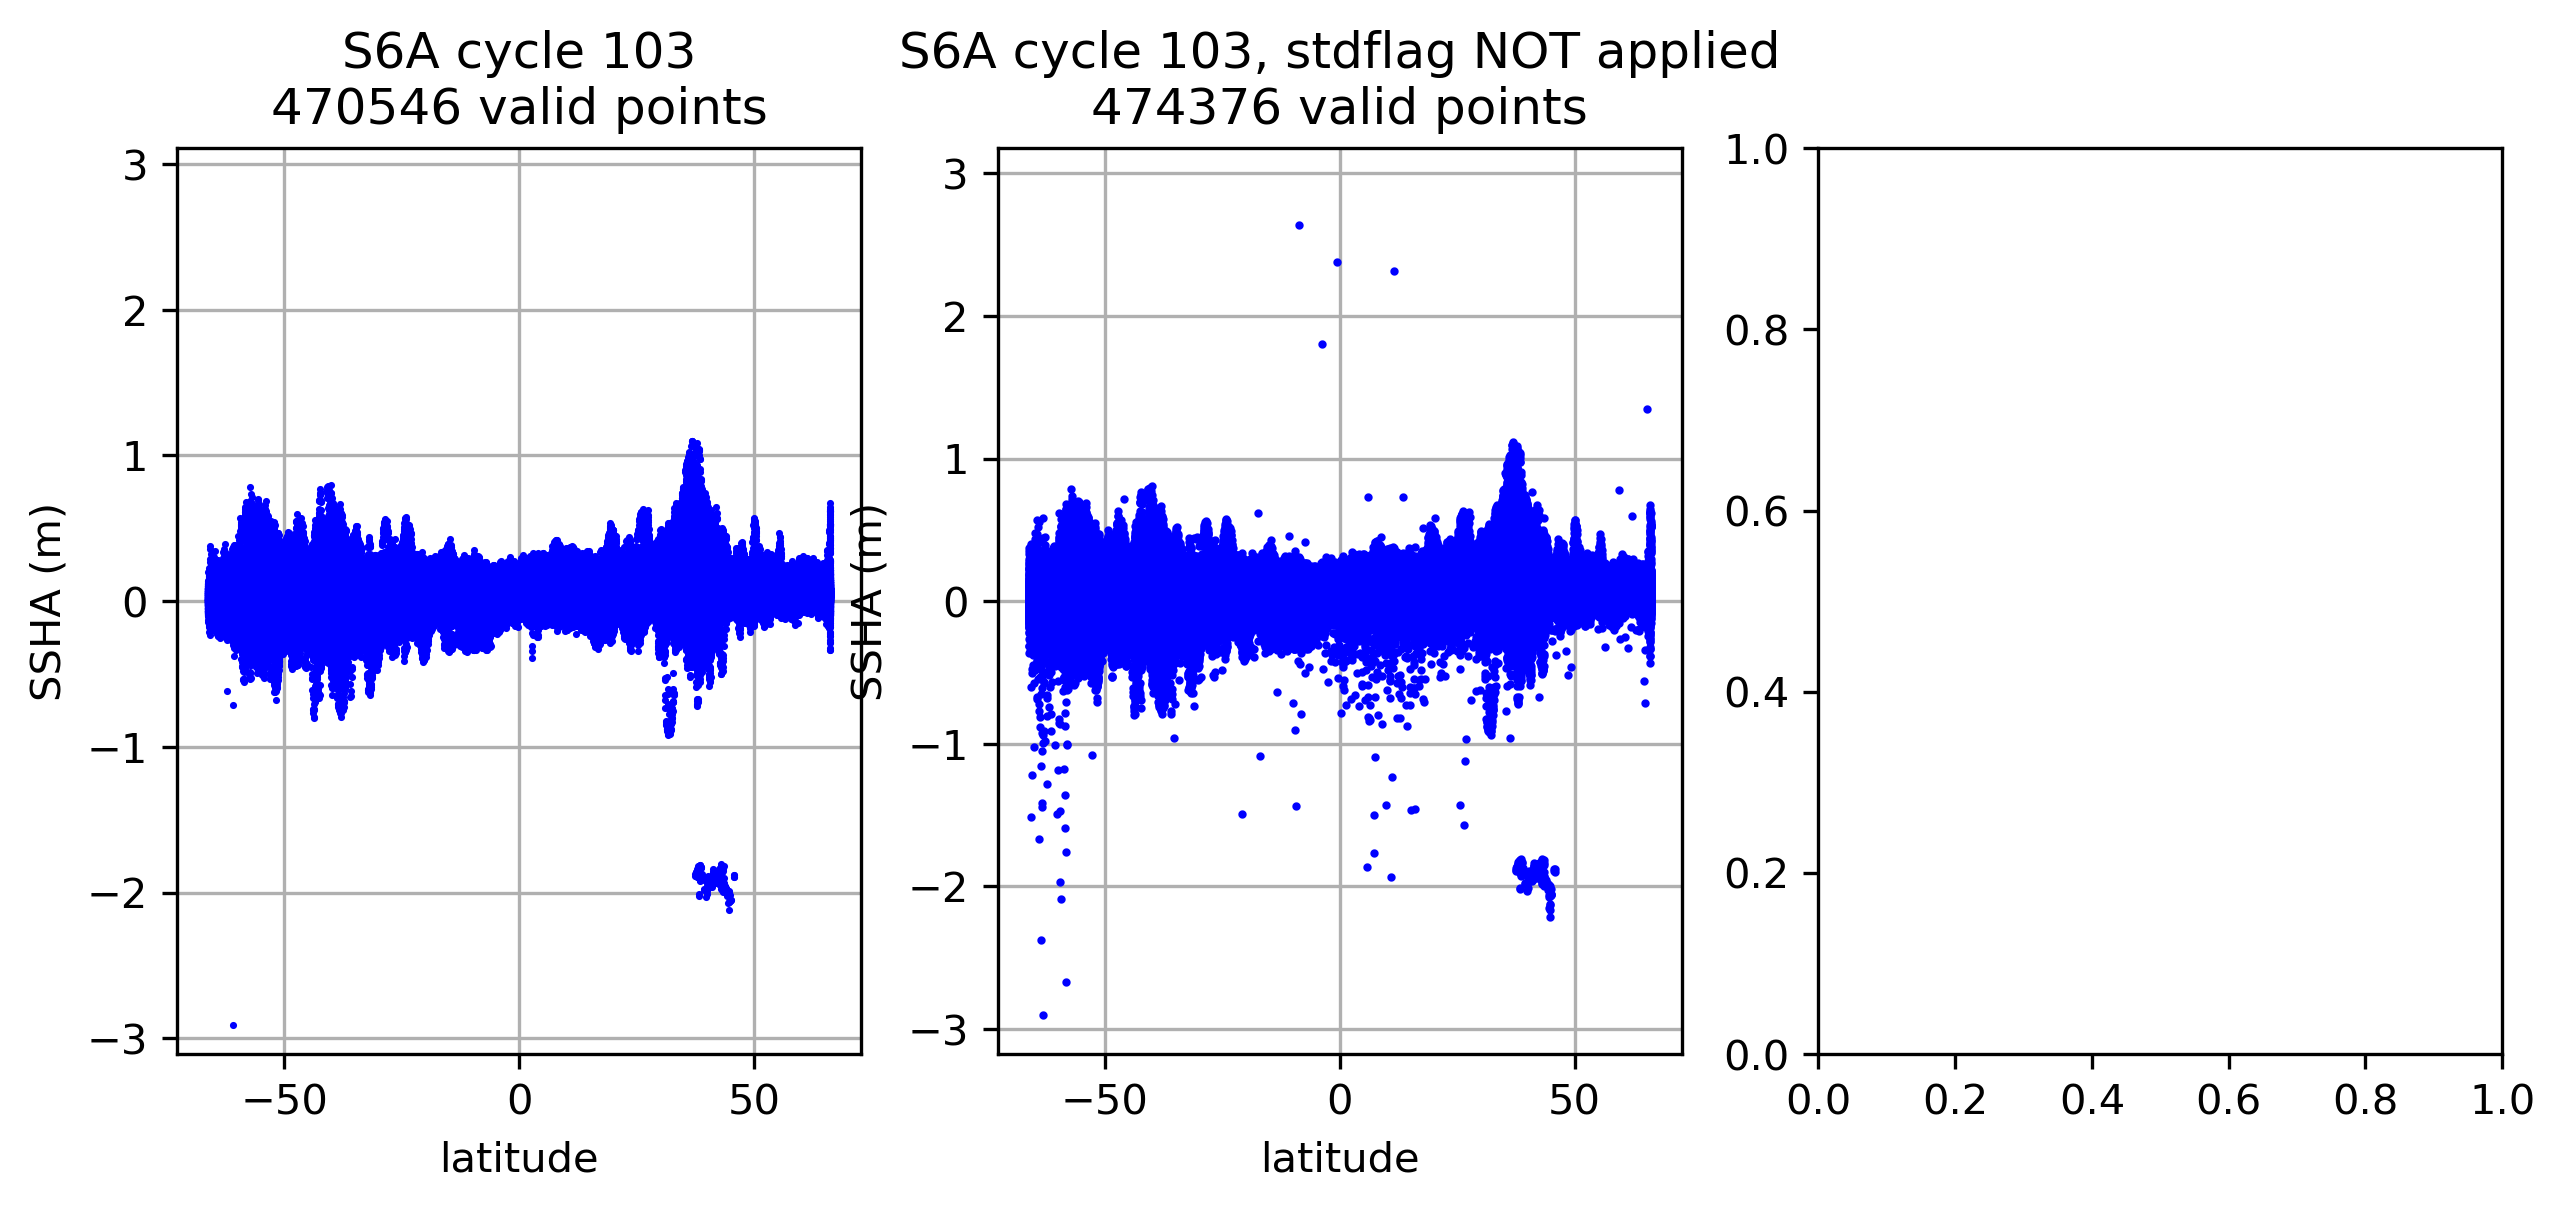

In [498]:
fig, axs = plt.subplots(1, 3, figsize=(10,4), dpi=300)

nasa_flag = (~np.isnan(ssh)) & ((surfc==0) | (surfc==2)) & (kqual==0) & (rain==0) & (rqual==0) & (~stdflag)
axs[0].grid()
axs[0].scatter(ds.latitude.values[nasa_flag], ssh[nasa_flag], s=.5, c='blue', zorder=100)
axs[0].set_ylabel('SSHA (m)')
axs[0].set_xlabel('latitude')
axs[0].set_title(f'S6A cycle 103\n{sum(nasa_flag)} valid points')
yabs_max = abs(max(axs[0].get_ylim(), key=abs))
axs[0].set_ylim(ymin=-yabs_max, ymax=yabs_max)

no_stdflag = ((surfc==0) | (surfc==2)) & (kqual==0) & (rain==0) & (rqual==0) & (~swflag) & (abs(ssh) < 5)
axs[1].grid()
axs[1].scatter(ds.latitude.values[no_stdflag], ssh[no_stdflag], s=1, c='blue', zorder=100)
axs[1].set_ylabel('SSHA (m)')
axs[1].set_xlabel('latitude')
axs[1].set_title(f'S6A cycle 103, stdflag NOT applied\n{sum(no_stdflag)} valid points')
yabs_max = abs(max(axs[1].get_ylim(), key=abs))
axs[1].set_ylim(ymin=-yabs_max, ymax=yabs_max)


(-1.0, 1.0)

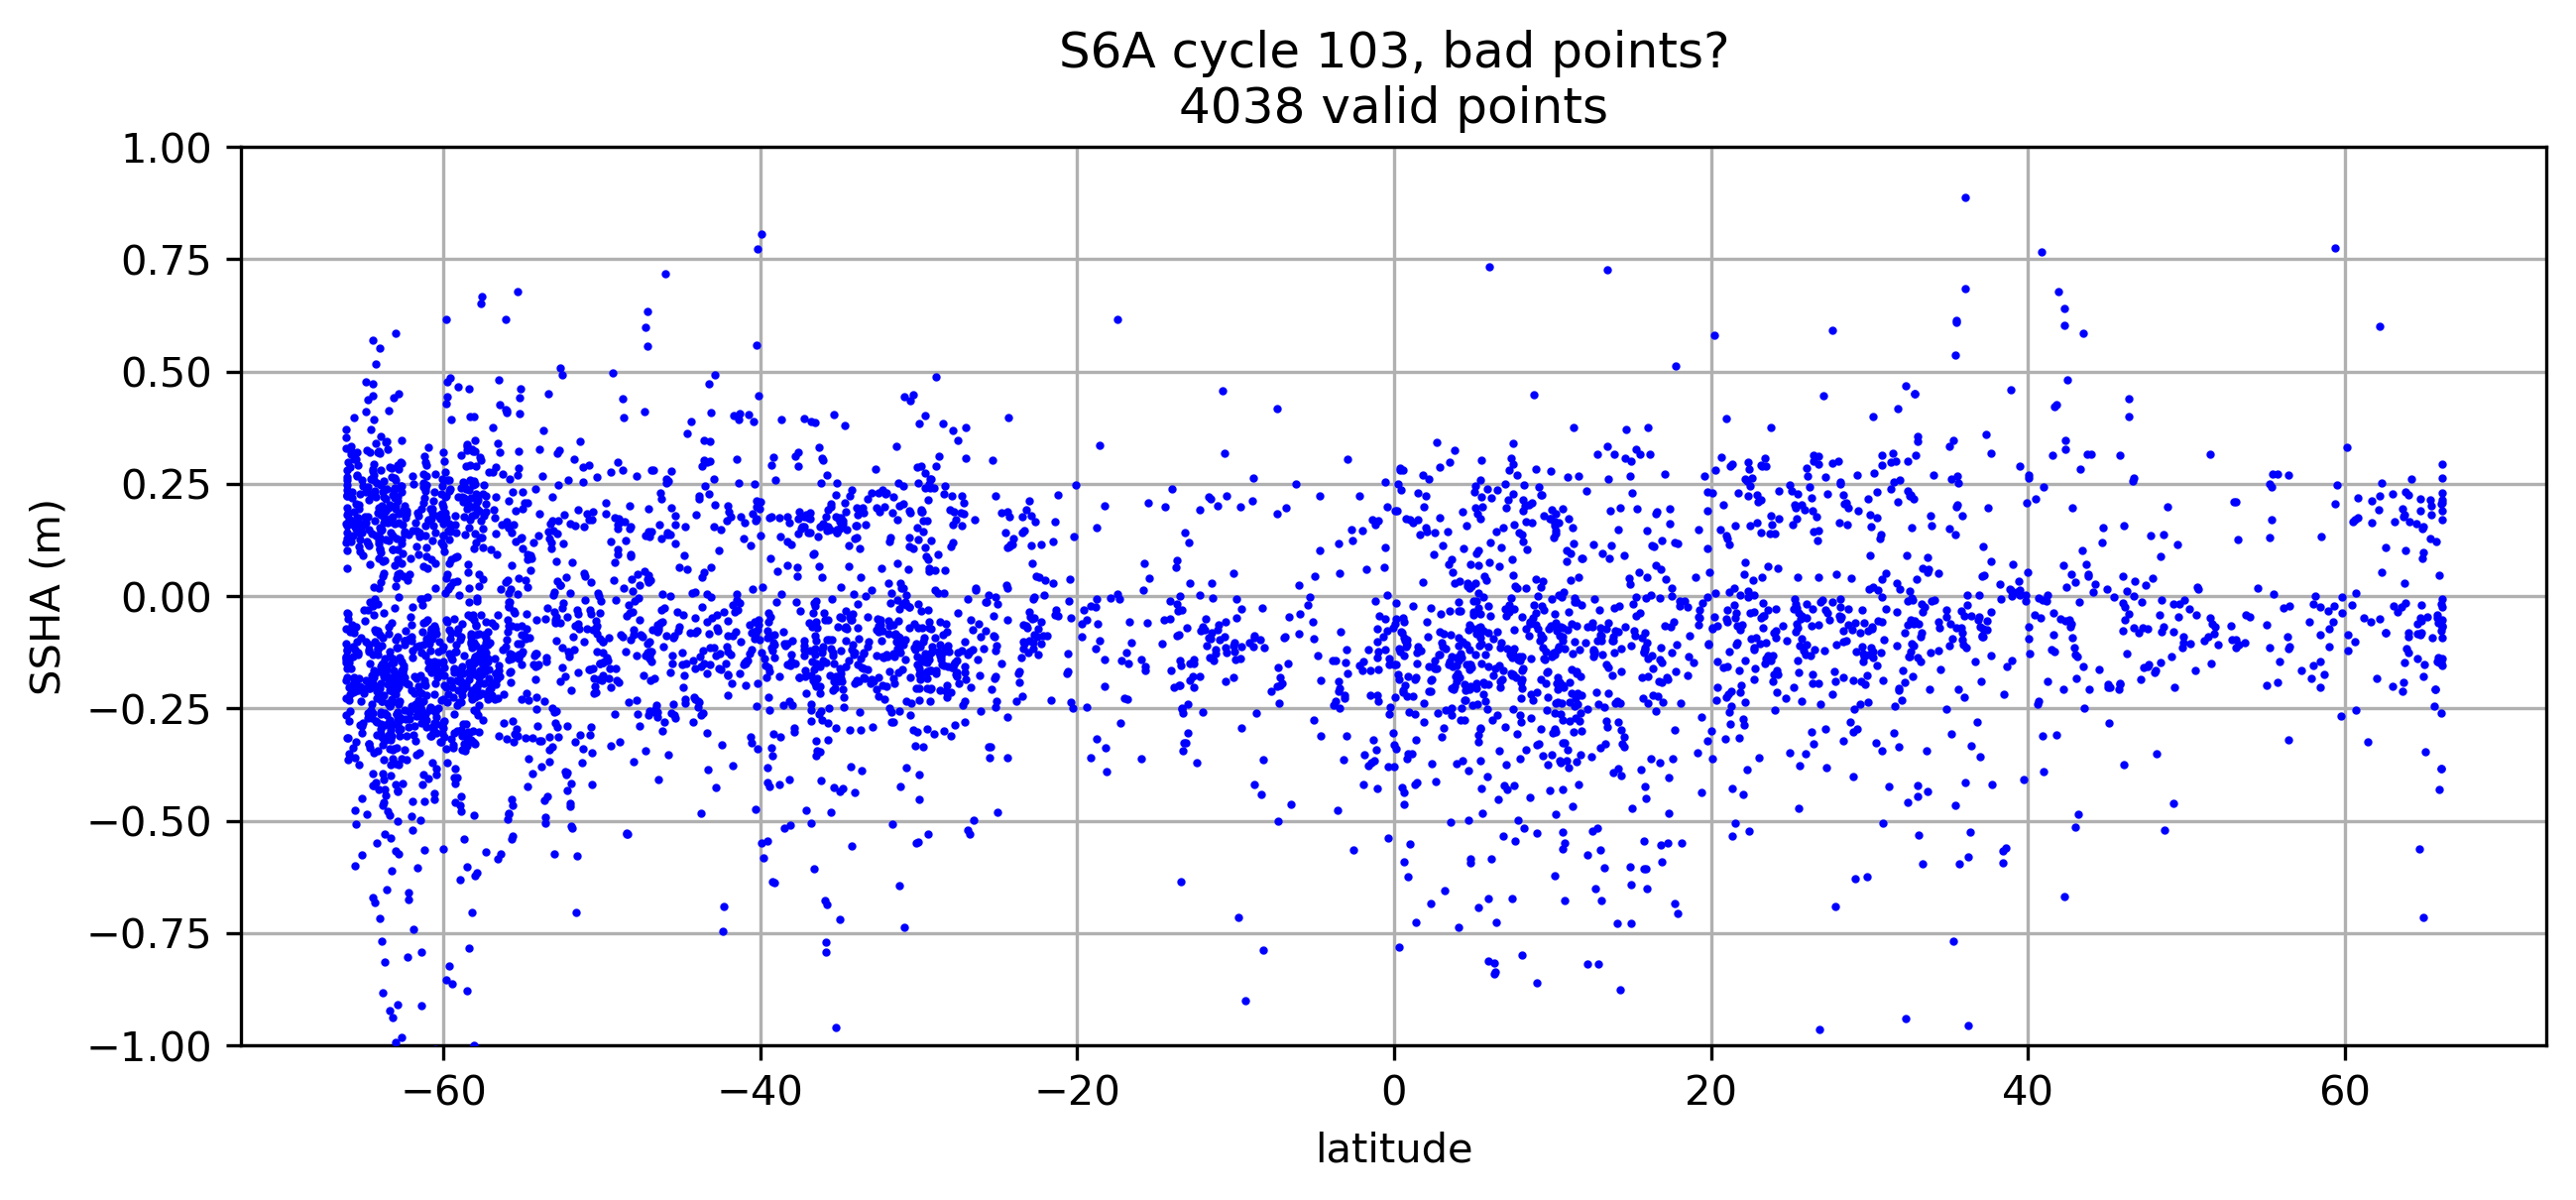

In [95]:
fig, plt.subplots(1, 1, figsize=(10,4), dpi=300)

no_stdflag = ((surfc==0) | (surfc==2)) & (kqual==0) & (rain==0) & (rqual==0) & (~swflag) & (abs(ssh) < 5)
test_flag = no_stdflag & ~nasa_flag
plt.grid()
plt.scatter(ds.latitude.values[test_flag], ssh[test_flag], s=1, c='blue', zorder=100)
plt.ylabel('SSHA (m)')
plt.xlabel('latitude')
plt.title(f'S6A cycle 103, bad points?\n{sum(test_flag)} valid points')
# yabs_max = abs(max(plt.get_ylim(), key=abs))
# plt.ylim(ymin=-yabs_max, ymax=yabs_max)
plt.ylim(-1,1)

In [499]:
ds = xr.open_dataset('/Users/username/Developer/Measures-Cloud/repos/daily_files/tests/testing_granules/gsfc/Merged_TOPEX_Jason_OSTM_Jason-3_Cycle_1080.V5_1.nc')
ds

<xarray.Dataset>
Dimensions:            (N_Records: 602834)
Coordinates:
    lat                (N_Records) float32 ...
    lon                (N_Records) float32 ...
    time               (N_Records) datetime64[ns] ...
Dimensions without coordinates: N_Records
Data variables:
    index              (N_Records) int16 ...
    reference_orbit    (N_Records) int16 ...
    mssh               (N_Records) float64 ...
    Distance_to_coast  (N_Records) float64 ...
    Surface_Type       (N_Records) float32 ...
    Bathymetry         (N_Records) float32 ...
    flag               (N_Records) int16 ...
    ssha               (N_Records) float32 ...
Attributes: (12/46)
    Conventions:                   CF-1.7, ACDD-1.3
    title:                         Integrated Multi-Mission Ocean Altimeter D...
    summary:                       Geo-registered along-track sea surface hei...
    source:                        TOPEX/Poseidon MGDR_B: Benada, J.R. 1997. ...
    processing_level:              2
    featureType:                   trajectory
    ...                            ...
    geospatial_vertical_units:     mm
    geospatial_vertical_positive:  up
    geospatial_lat_resolution:     0.05
    geospatial_lon_resolution:     2.83
    geospatial_vertical_min:       -9717
    geospatial_vertical_max:       10218

In [500]:
ssh = ds.ssha.values / 1000
surf_type = ds.Surface_Type.values
flag = ds.flag.values

In [501]:
max_bits = int(np.ceil(np.log2(flag.max())))

# Initialize an empty 2D boolean array
bin_array = np.zeros((len(flag), max_bits), dtype=bool)

# Convert integers to binary strings and split into bits
for i, num in enumerate(flag):
    binary_string = np.binary_repr(num, width=max_bits)
    bin_array[i] = [bool(int(bit)) for bit in binary_string]

In [502]:
# Select columns of interest, determine single boolean value
valid_array = ~bin_array[:, [1, 2, 3, 4, 5, 9]].any(axis=1)
valid_array

array([False, False, False, ..., False, False, False])

In [503]:
pflag = ((surf_type == 0) | (surf_type == 2)) & (valid_array) & (~np.isnan(ssh))

In [504]:
# Make stdflag
nmedian = 15
nstd = 95
timestamps = np.arange(1, len(ssh)+1)

rolling_median = pd.Series(ssh[pflag]).rolling(nmedian, center=True, min_periods=1).median().values
dx = ssh[pflag] - rolling_median

dx_median = pd.Series(np.square(dx)).rolling(nstd, center=True, min_periods=1).median().values
rolling_std = dx_median.clip(np.sqrt(dx_median), 0.05, None)

median_interp = np.interp(timestamps, timestamps[pflag], rolling_median)
std_interp = np.interp(timestamps, timestamps[pflag], rolling_std)

stdflag = abs(ssh - median_interp) <= std_interp * 5

In [505]:
nasa_flag = pflag & stdflag

(-1.3804999589920044, 1.3804999589920044)

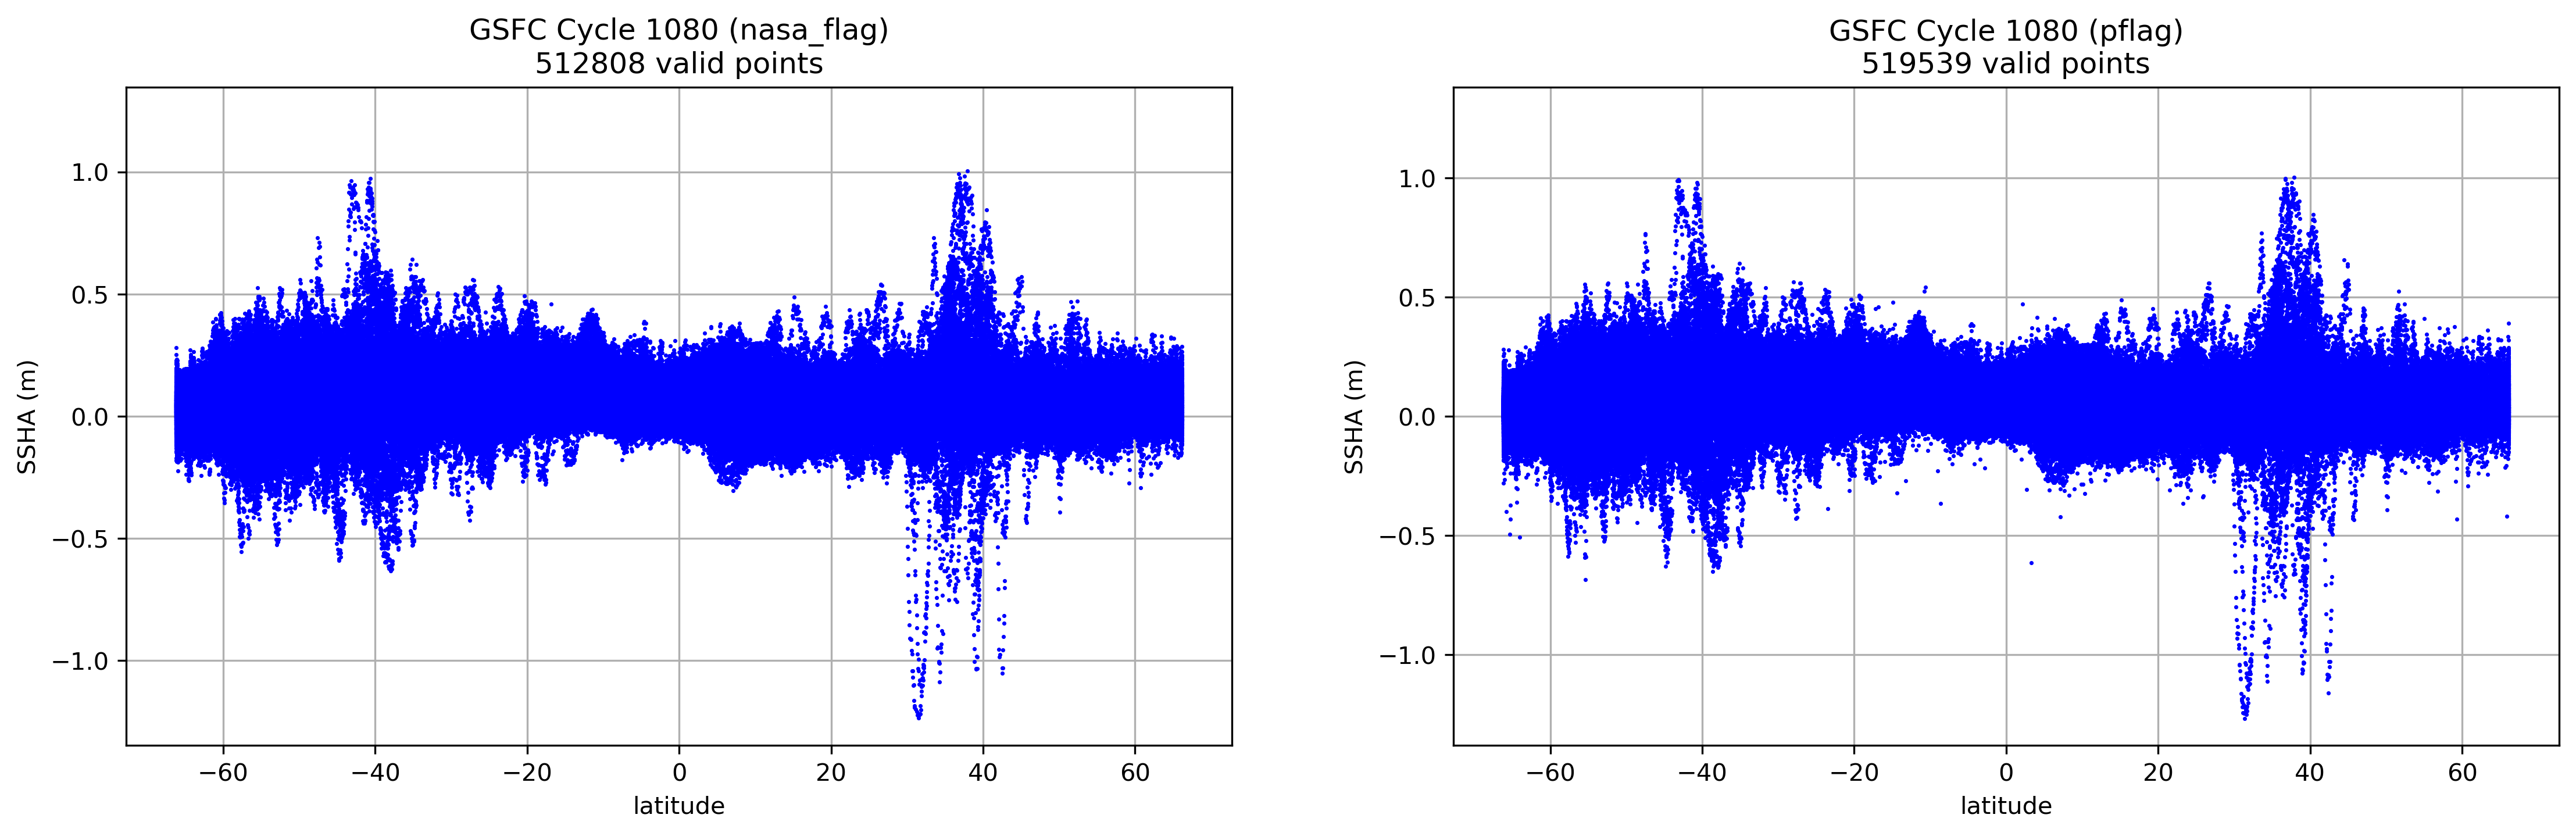

In [507]:
fig, axs = plt.subplots(1, 2, figsize=(18,5), dpi=300)

axs[0].grid()
axs[0].scatter(ds.lat.values[nasa_flag], ssh[nasa_flag], s=.5, c='blue', zorder=100)
axs[0].set_ylabel('SSHA (m)')
axs[0].set_xlabel('latitude')
axs[0].set_title(f'GSFC Cycle 1080 (nasa_flag)\n{sum(nasa_flag)} valid points')
yabs_max = abs(max(axs[0].get_ylim(), key=abs))
axs[0].set_ylim(ymin=-yabs_max, ymax=yabs_max)

axs[1].grid()
axs[1].scatter(ds.lat.values[pflag], ssh[pflag], s=.5, c='blue', zorder=100)
axs[1].set_ylabel('SSHA (m)')
axs[1].set_xlabel('latitude')
axs[1].set_title(f'GSFC Cycle 1080 (pflag)\n{sum(pflag)} valid points')
yabs_max = abs(max(axs[1].get_ylim(), key=abs))
axs[1].set_ylim(ymin=-yabs_max, ymax=yabs_max)